# 2. Digits Classification with $K$ Nearest Neighbors (40 points)
In this question you will implement and apply the $K$ Nearest Neighbors learning algorithm to classify handwritten digits. You should make your own implementation (rather than use libraries), but it is allowed to use library functions for vector and matrix operations.

- MNIST-5-6-Subset.txt is a space-separated file of real numbers (written as text). It contains a 784 × 1877 matrix, written column-by-column (the first 784 numbers in the file correspond to the first column; the next 784 numbers are the second column, and so on).
  – Each column in the matrix is a 28 × 28 grayscale image of a digit, stored column-by-column (the first 28 out of 784 values correspond to the first column of the 28×28 image, the next 28 values correspond to the second column, and so on). Below the question is a Python script that serves as an illustration of one way to load and visualize the data.
- MNIST-5-6-Subset-Labels.txt is a space-separated file of 1877 integers. The numbers label the images in MNIST-5-6-Subset.txt file: the first number ("5") is the number drawn in the image corresponding to the first column; the second number corresponds to the second column, and so on.
- Light-Corruption, Moderate-Corruption, and Heavy-Corruption are corrupted versions of the digits in MNIST-5-6-Subset.txt, the order is preserved. It is a good idea to visualize the corrupted images to get some feeling of the corruption.

## Task #1

In order to explore fluctuations of the validation error as a function of the size of the validation set, we use the following construction:
- Implement a Python function `knn(training_points, training_labels, test_point, test_label)` that takes as input a $d \times m$ matrix of training points `training_points`, where $m$ is the number of training points and $d$ is the dimension of each point ($d = 784$ in the case of digits), a vector training_labels of the corresponding m training labels, a $d$-dimensional vector `text_point` representing one test point, and its label `test_label` $\in \{−1, 1\}$ (you will need to convert the labels from $\{5, 6\}$ to $\{−1, 1\}$). The function should return a binary vector of length $m$, where each element represents the error of K-NN for the corresponding value of $K$ for $K \in \{1, ..., m\}$. Include a printout of your implementation of the function in the report. (Only this function, not all of your code, the complete code should be included in the .zip file.) Ideally, the function should have no for-loops, check the practical advice at the end of the question.
- Use the first $m$ digits for training the K-NN model. Take $m = 50$.
- Consider five validation sets, where for $i \in \{1, ..., 5\}$ the set $i$ consists of digits $m + (i \times n) + 1, ..., m + (i + 1) \times n$, and where $n$ is the size of each of the five validation sets (we will specify $n$ in a moment). The data split is visualized below.
- Calculate the validation error for each of the sets as a function of $K$, for $K \in \{1, ..., m\}. Plot the validation error for each of the five validation sets as a function of $K$ in the same figure (you will get five lines in the figure).
- Execute the experiment above with $n \in \{10, 20, 40, 80\}$. You will get four figures for the four values of $n$, with five lines in each figure. Include these four figures in your report.
- Create a figure where for each $n \in \{10, 20, 40, 80\}$ you plot the variance of the validation error over the five validation sets, as a function of $K$. You will get four lines in this figure, one for each $n$. Include this figure in your report. (Clarification, in case you got confused: fix $n$ and $K$, then you have five numbers corresponding to validation errors on the five validation sets. You should compute the variance of these five values. Now keep $n$ fixed, take $K \in \{1, ..., m\}$, and compute the variance as a function of $K$, i.e., compute it for each $K$ separately. This gives you one line. And then each $n \in \{10, 20, 40, 80\}$ gives you a line, so you get four lines.)
- What can you say about fluctuations of the validation error as a function of $n$? Answer in the report.
- What can you say about the prediction accuracy of K-NN as a function of $K$? Answer in the report.
- A high-level comment: a more common way of visualizing variation of outcomes of experiment repetitions is to plot the mean and error bars, but this form of visualization makes it too easy for humans to ignore the error bars and concentrate just on the mean, see the excellent book of Kahneman
(2011). The visualization you are asked to provide in this question makes it hard to ignore the variation.

## Task #2

In order to explore the influence of corruptions on the performance of K-NN and on the optimal value of $K$, we use this construction:
- Take the uncorrupted set, take $m$ as before and $n = 80$, and construct training and validation sets as above. Plot five lines for the five validation sets, as a function of $K$, for $K \in \{1, ..., m\}$. Include this figure in your report.
- Repeat the experiment with the Light-Corruption set (both training and test images should be taken from the lightly corrupted set), then with the Moderate-Corruption set, and then with the Heavy-Corruption set. Include one figure for each of the corrupted sets in your report.
- Discuss how corruption magnitude influences the prediction accuracy of K-NN and the optimal value of $K$. Answer in the report.

In [57]:
import numpy as np
import matplotlib.pyplot as plt


class KNN:
    def __init__(self, name: str, data_file_path: str, output_path: str, n_values: list, skip_variance: bool = False):
        self.name = name
        self.output_path = output_path

        self.n_values = n_values

        self.skip_variance = skip_variance

        self.num_validation_sets = 5  # same number of validation sets for all experiments

        self.m = 50  # same number of training points for all experiments

        self.K = np.arange(1, self.m + 1)  # same K values for all experiments

        self.y_max_validation = 0.65  # same y_max for validation plots for all experiments

        # Same labels will be used for all the experiments
        labels_file_path = "data/MNIST-5-6-Subset-Labels.txt"
        labels = np.loadtxt(labels_file_path)
        self.labels = np.where(labels == 5, -1, 1)  # convert labels from {5, 6} to {-1, 1}

        self.data = np.loadtxt(data_file_path).reshape(1877, 784)  # load data and reshape into 1877 rows and 784 columns

        # Define training points and labels
        self.training_points = self.data[: self.m]
        self.training_labels = self.labels[: self.m]

    def knn(self, test_point, test_label):
        # 2. Calculate pairwise distances (d_i = d(x_i, x)) between test point and training points using euclidean distance.
        distances = np.sum(np.square((self.training_points - test_point)), axis=1)

        # 3. Sort distances (d_i's) in ascending order and get corresponding indices
        distances_sorted_indices = np.argsort(distances)

        # 4. Calculate the summed up sign of the labels of the K nearest neighbors (majority vote).
        ys = np.sign(np.cumsum(self.training_labels[distances_sorted_indices]))

        # If voting tie, only look at the K-1 neighbors.
        # Wherever ys=0 (i.e. a tie), replace it with the value one position to the right (i.e. label of previous neighbor),
        # otherwise keep the original value of ys."
        ys = np.where(ys == 0, np.roll(ys, 1), ys)  # np.roll(ys, 1) shifts array one position to the right

        errors = np.where(ys != test_label, 1, 0)

        return errors

    def validation(self):
        if not self.skip_variance:
            fig1, ax1 = plt.subplots(figsize=(8, 5))

        optimal_K_values = []  # List to store optimal K values for each n

        for n in self.n_values:
            fig2, ax2 = plt.subplots(figsize=(8, 5))

            mean_validation_errors_of_sets = []

            for i in range(self.num_validation_sets):
                # Define validation set
                start_idx = self.m + i * n
                end_idx = self.m + (i + 1) * n

                validation_points = self.data[start_idx:end_idx]
                validation_labels = self.labels[start_idx:end_idx]

                # Calculate mean validation error for each K
                mean_validation_errors_of_set = self._mean_validation_error(validation_points, validation_labels)

                ax2.plot(self.K, mean_validation_errors_of_set, label=f"Validation set {i+1}")

                # Calculate variance of validation error for comparing validation sets
                mean_validation_errors_of_sets.append(mean_validation_errors_of_set)

            # Finding optimal K using the refined Elbow method (for the average of all validation sets)
            mean_errors = np.mean(mean_validation_errors_of_sets, axis=0)
            diff_errors = np.diff(mean_errors)
            optimal_K = np.argmin(np.abs(diff_errors)) + 1  # +1 to adjust for 0-based index
            optimal_K_values.append(optimal_K)

            # Highlighting the optimal K on the plot
            ax2.axvline(x=optimal_K, color='r', linestyle='--', label=f'Optimal K = {optimal_K}')
            ax2.legend()

            # Plot settings
            ax2.set_xlabel("K", fontsize=12)
            ax2.set_ylabel("Validation error", fontsize=12)
            ax2.set_title(f"{self.name}: Validation error\nK=(1,...,{self.m}); m={self.m}; n={n}", fontsize=14)
            ax2.grid(alpha=0.2)
            ax2.set_ylim([0, self.y_max_validation])
            fig2.tight_layout()
            fig2.savefig(self.output_path + f"/validation_err_n={n}.png")

            if self.skip_variance:
                continue

            # Stack the validation errors, so that we can calculate the variance of n
            mean_validation_errors_stacked_of_sets = np.vstack(mean_validation_errors_of_sets)
            variance_of_n = np.var(mean_validation_errors_stacked_of_sets, axis=0)

            # Plot the variance of the validation error as a function of K
            ax1.plot(self.K, variance_of_n, label=f"n={n}")
            ax1.set_xlabel("K", fontsize=12)
            ax1.set_ylabel("Variance of validation error", fontsize=12)
            ax1.set_title(f"{self.name}: Variance of validation error\nK=(1,...,{self.m}); m={self.m}", fontsize=14)
            ax1.grid(alpha=0.2)
            ax1.legend()

        if not self.skip_variance:
            fig1.tight_layout()
            fig1.savefig(self.output_path + f"/variance_of_validation_error.png")

        plt.show()

        # Print Optimal K for each n
        for n_val, k_val in zip(self.n_values, optimal_K_values):
            print(f"For n = {n_val}, Optimal K = {k_val}")

    def _mean_validation_error(self, validation_points: np.ndarray, validation_labels: np.array):
        validation_errors = np.zeros(self.m)

        for validation_point, validation_label in zip(validation_points, validation_labels):
            validation_error = self.knn(validation_point, validation_label)
            validation_errors += validation_error

        # Divide by n to get the average error for each K
        mean_validation_errors = validation_errors / validation_labels.shape[0]  # validation_labels.shape[0] = n

        return mean_validation_errors
    
    # EXTRAS:
    def plot_label_distribution(self):
        # Calculate the percentage of each label
        negative_percentage = (sum(1 for label in self.labels if label == -1) / len(self.labels)) * 100
        positive_percentage = (sum(1 for label in self.labels if label == 1) / len(self.labels)) * 100
        
        # Plotting
        plt.figure(figsize=(3, 3))
        plt.bar([-1, 1], [negative_percentage, positive_percentage], width=0.4, color=['salmon', 'lightblue'], align='center')
        plt.ylim([0, 100])
        plt.title("Label distribution")
        plt.xlabel("Label")
        plt.ylabel("Percentage")
        plt.xticks([-1, 1])  # Only show labels -1 and 1 on the x-axis
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

# Uncorrupted experiment

For n = 10, Optimal K = 1
For n = 20, Optimal K = 1
For n = 40, Optimal K = 1
For n = 80, Optimal K = 1
For n = 10, Optimal K = 1
For n = 20, Optimal K = 1
For n = 40, Optimal K = 1
For n = 80, Optimal K = 1
For n = 10, Optimal K = 1
For n = 20, Optimal K = 1
For n = 40, Optimal K = 1
For n = 80, Optimal K = 1
For n = 10, Optimal K = 1
For n = 20, Optimal K = 1
For n = 40, Optimal K = 1
For n = 80, Optimal K = 1


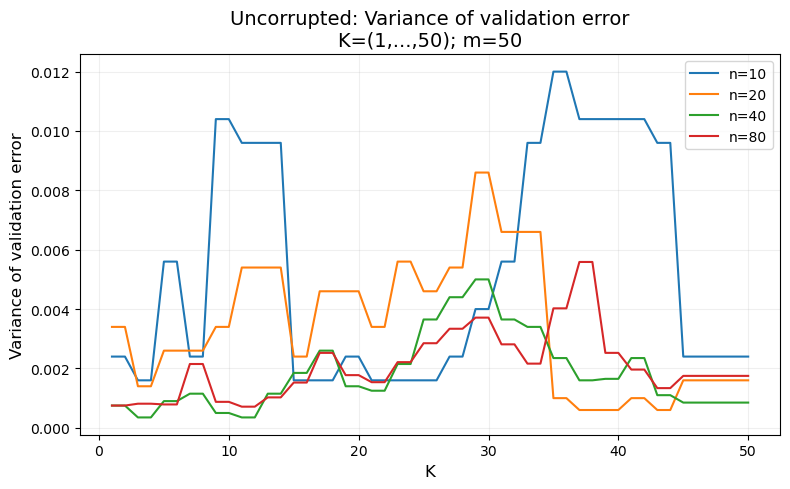

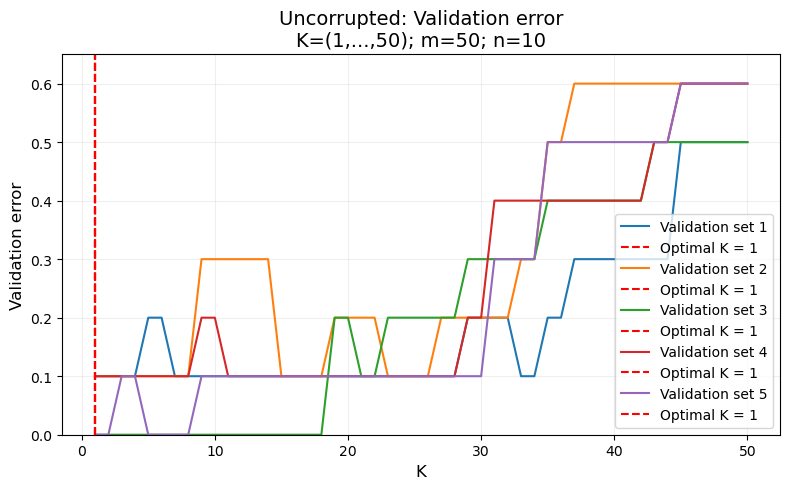

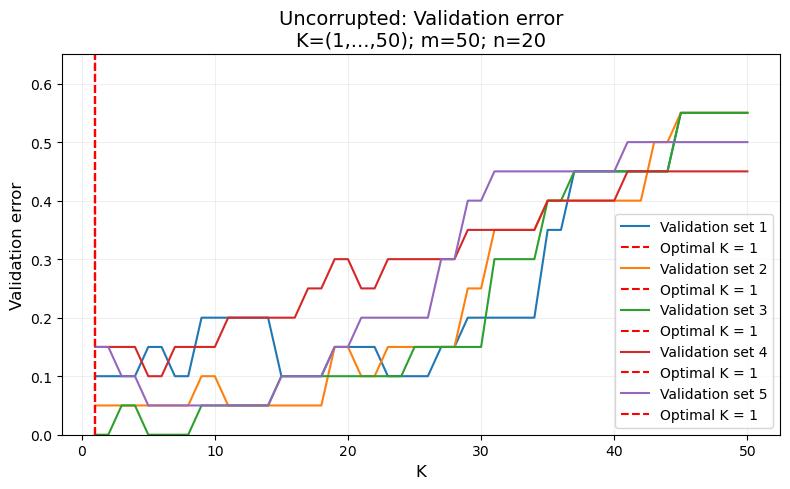

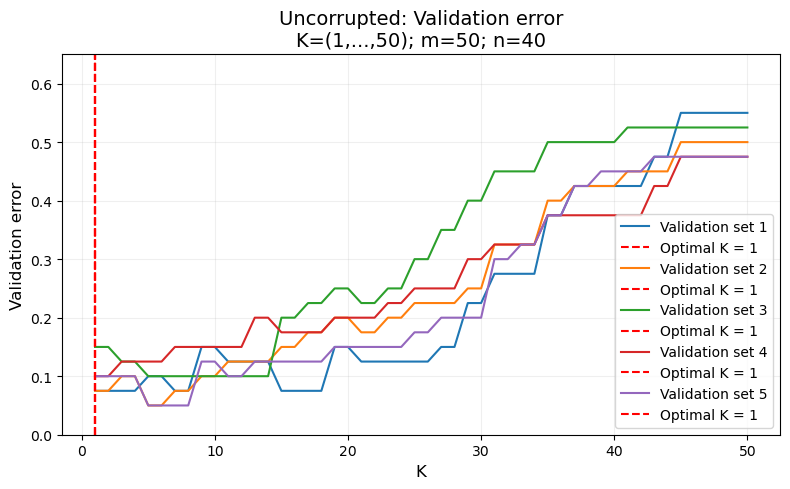

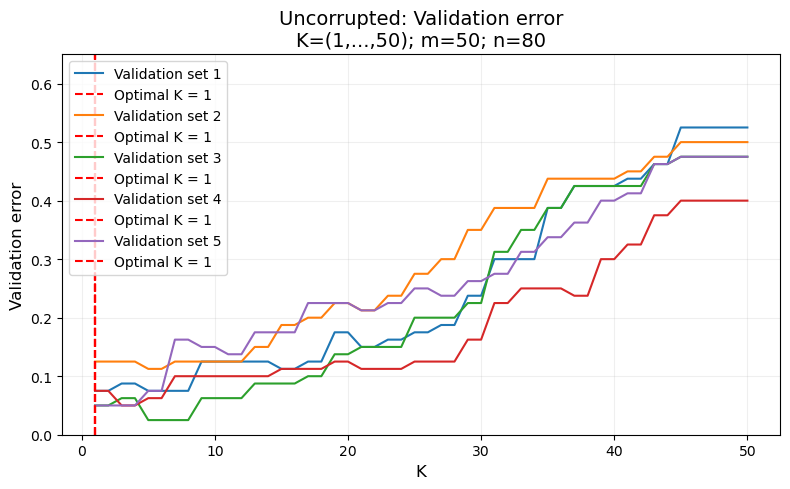

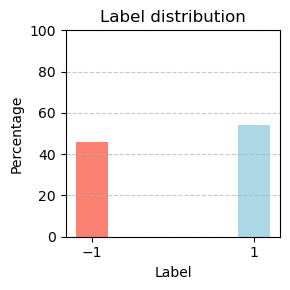

In [58]:
uncorrupted = KNN(name="Uncorrupted", data_file_path="data/MNIST-5-6-Subset.txt", output_path="images/uncorrupted", n_values=[10, 20, 40, 80])
uncorrupted.validation()
uncorrupted.plot_label_distribution()

# Light corruption experiment

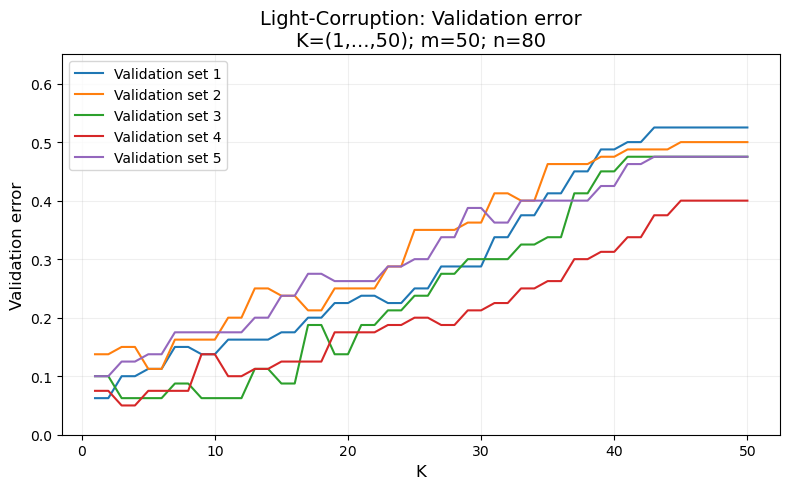

In [8]:
light_corruption = KNN(
    name="Light-Corruption",
    data_file_path="data/MNIST-5-6-Subset-Light-Corruption.txt",
    output_path="images/light_corruption",
    n_values=[80],
    skip_variance=True,
)
light_corruption.validation()

# Moderate corruption experiment

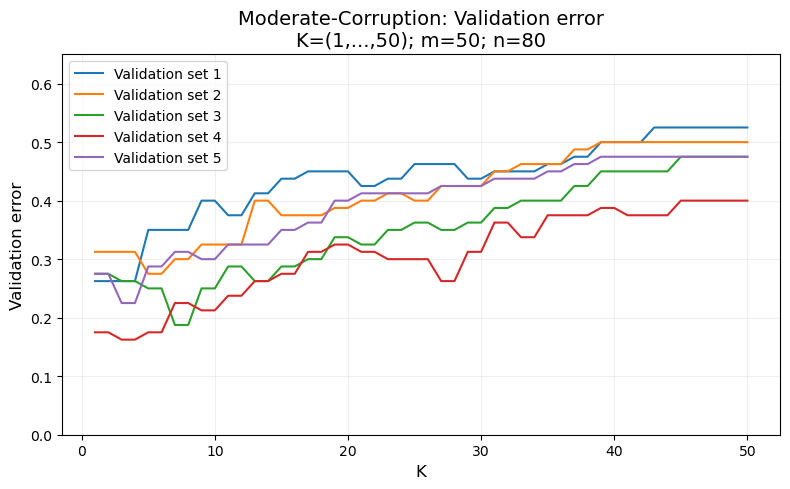

In [9]:
moderate_corruption = KNN(
    name="Moderate-Corruption",
    data_file_path="data/MNIST-5-6-Subset-Moderate-Corruption.txt",
    output_path="images/moderate_corruption",
    n_values=[80],
    skip_variance=True,
)
moderate_corruption.validation()

# Heavy corruption experiment

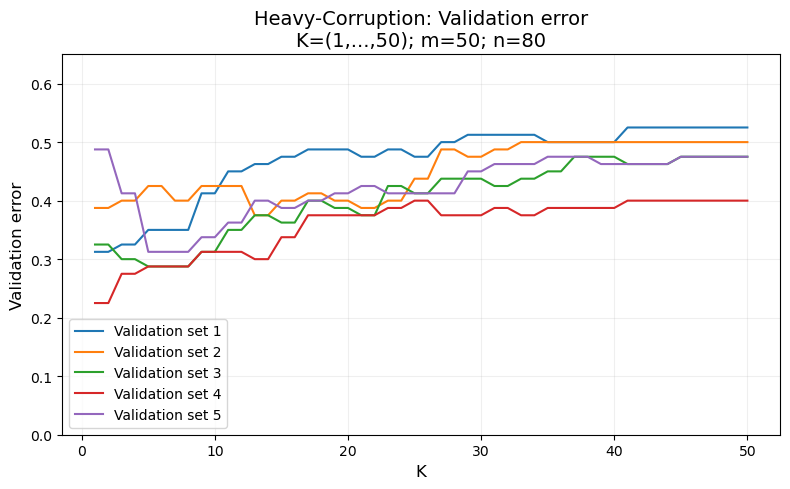

In [10]:
heavy_corruption = KNN(
    name="Heavy-Corruption",
    data_file_path="data/MNIST-5-6-Subset-Heavy-Corruption.txt",
    output_path="images/heavy_corruption",
    n_values=[80],
    skip_variance=True,
)
heavy_corruption.validation()